In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/exports/home/jolivieri/equivalence_testing/scripts/')

from equiv_test_funcs import *

In [8]:
def ttests(df):
    
    # run t tests from script (should be what's done in perform tests)

    if norm:
      # normalize each row (sample) by the number of counts
        df = normalize(df)

    if log_scale:
        df = log2_scale(df)

    plot = False

    # testing out function you can use in Python code
    # perform_tests_for_df(df, args.delta)

    out_df = loop_over_genes(df, delta, plot)

    out_df = process_out_df(out_df, delta)
    #display(out_df.head())
    return out_df["sig_diff"][0], out_df["sig_equiv"][0]

In [9]:
outpath = "/exports/home/jolivieri/equivalence_testing_output/notebooks/output/simulation/"
numReads = [5, 10, 50, 100, 500, 1000]

numReads = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200]

num_trials = 10

num_samples = 3

geneA_fracs = [0.3, 0.6]

geneA_fracs = [0.2, 0.8]

geneA_fracs = [0.45, 0.55]

geneA_fracs = [0.1, 0.15]

geneA_fracs = [0.01, 0.015]

geneA_fracs = [0.05, 0.1]

norm = True
log_scale = True

delta = 1
alpha = 0.05

In [10]:
np.random.seed(123)

out = {"numReads" : [], "frac_sig_diff" : [], "frac_sig_diff_lower" : [], "frac_sig_diff_upper" : [], 
       "frac_sig_equiv" : [], "frac_sig_equiv_lower" : [], "frac_sig_equiv_upper" : [], 
       "frac_sig_inc" : [], "frac_sig_inc_lower" : [], "frac_sig_inc_upper" : []}

for num in numReads:
    print("num reads: {}".format(num))
    # collect p vals for each
    num_sig_diff = 0
    num_sig_equiv = 0
    num_inconclusive = 0
    
    for i in range(num_trials):
        data = {"sample" : [], "A" : [], "B" : [], "cell_type" : []}
        count = 0
        for j in range(len(geneA_fracs)):
            for k in range(num_samples):
                count += 1
                
                # add 1 so it's never zero
                n = np.random.poisson(num) + 1
                A = np.random.binomial(n, geneA_fracs[j])
                data["sample"].append("sample" + str(count))
                data["A"].append(A)
                data["B"].append(n - A)
                data["cell_type"].append(j)
        df = pd.DataFrame(data).set_index("sample")
        
        # get results
        diff_sig, equiv_sig = ttests(df)
        
        # save output
        num_sig_diff += diff_sig
        num_sig_equiv += equiv_sig
        num_inconclusive += 1 - diff_sig - equiv_sig
        
    # get frac significant
    out["numReads"].append(num)

#    num_sig_diff = sum(1 for p in diff_pvals if p < alpha)
    lower_ci, upper_ci = proportion_confint(num_sig_diff, num_trials)
    out["frac_sig_diff"].append(num_sig_diff/num_trials)
    out["frac_sig_diff_lower"].append(lower_ci)
    out["frac_sig_diff_upper"].append(upper_ci)

#    num_sig_equiv = sum(1 for p in equiv_pvals if p < alpha)
    lower_ci, upper_ci = proportion_confint(num_sig_equiv, num_trials)
    out["frac_sig_equiv"].append(num_sig_equiv/num_trials)
    out["frac_sig_equiv_lower"].append(lower_ci)
    out["frac_sig_equiv_upper"].append(upper_ci)
    

#    num_sig_equiv = sum(1 for p in equiv_pvals if p < alpha)
    lower_ci, upper_ci = proportion_confint(num_inconclusive, num_trials)
    out["frac_sig_inc"].append(num_inconclusive/num_trials)
    out["frac_sig_inc_lower"].append(lower_ci)
    out["frac_sig_inc_upper"].append(upper_ci)
out = pd.DataFrame(out)
display(out)

num reads: 1


  0%|          | 0/2 [00:00<?, ?it/s]/exports/home/jolivieri/equivalence_testing/scripts/equiv_test_funcs.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  t1 = (np.mean(group1_vals) - np.mean(group2_vals) - delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
/exports/home/jolivieri/equivalence_testing/scripts/equiv_test_funcs.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  t2 = (np.mean(group1_vals) - np.mean(group2_vals) + delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
  0%|          | 0/2 [00:00<?, ?it/s]/exports/home/jolivieri/equivalence_testing/scripts/equiv_test_funcs.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  t1 = (np.mean(group1_vals) - np.mean(group2_vals) - delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
/exports/home/jolivieri/equivalence_testing/scripts/equiv_test_funcs.py:44: Runtime

num reads: 2


  0%|          | 0/2 [00:00<?, ?it/s]/exports/home/jolivieri/equivalence_testing/scripts/equiv_test_funcs.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  t1 = (np.mean(group1_vals) - np.mean(group2_vals) - delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
/exports/home/jolivieri/equivalence_testing/scripts/equiv_test_funcs.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  t2 = (np.mean(group1_vals) - np.mean(group2_vals) + delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
  0%|          | 0/2 [00:00<?, ?it/s]/exports/home/jolivieri/equivalence_testing/scripts/equiv_test_funcs.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  t1 = (np.mean(group1_vals) - np.mean(group2_vals) - delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
/exports/home/jolivieri/equivalence_testing/scripts/equiv_test_funcs.py:44: Runtime

num reads: 3


  0%|          | 0/2 [00:00<?, ?it/s]/exports/home/jolivieri/equivalence_testing/scripts/equiv_test_funcs.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  t1 = (np.mean(group1_vals) - np.mean(group2_vals) - delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
/exports/home/jolivieri/equivalence_testing/scripts/equiv_test_funcs.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  t2 = (np.mean(group1_vals) - np.mean(group2_vals) + delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
100%|██████████| 2/2 [00:00<00:00, 377.80it/s]


num reads: 4


  0%|          | 0/2 [00:00<?, ?it/s]/exports/home/jolivieri/equivalence_testing/scripts/equiv_test_funcs.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  t1 = (np.mean(group1_vals) - np.mean(group2_vals) - delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
/exports/home/jolivieri/equivalence_testing/scripts/equiv_test_funcs.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  t2 = (np.mean(group1_vals) - np.mean(group2_vals) + delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
  0%|          | 0/2 [00:00<?, ?it/s]/exports/home/jolivieri/equivalence_testing/scripts/equiv_test_funcs.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  t1 = (np.mean(group1_vals) - np.mean(group2_vals) - delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))
/exports/home/jolivieri/equivalence_testing/scripts/equiv_test_funcs.py:44: Runtime

num reads: 5


100%|██████████| 2/2 [00:00<00:00, 457.49it/s]


num reads: 10


100%|██████████| 2/2 [00:00<00:00, 461.19it/s]


num reads: 15


100%|██████████| 2/2 [00:00<00:00, 452.68it/s]


num reads: 20


100%|██████████| 2/2 [00:00<00:00, 458.97it/s]


num reads: 25


100%|██████████| 2/2 [00:00<00:00, 492.26it/s]


num reads: 30


100%|██████████| 2/2 [00:00<00:00, 491.74it/s]


num reads: 35


100%|██████████| 2/2 [00:00<00:00, 459.15it/s]


num reads: 40


100%|██████████| 2/2 [00:00<00:00, 460.53it/s]


num reads: 45


100%|██████████| 2/2 [00:00<00:00, 460.89it/s]


num reads: 50


100%|██████████| 2/2 [00:00<00:00, 492.03it/s]


num reads: 100


100%|██████████| 2/2 [00:00<00:00, 491.08it/s]


num reads: 150


100%|██████████| 2/2 [00:00<00:00, 472.07it/s]


num reads: 200


100%|██████████| 2/2 [00:00<00:00, 459.12it/s]


,numReads,frac_sig_diff,frac_sig_diff_lower,frac_sig_diff_upper,frac_sig_equiv,frac_sig_equiv_lower,frac_sig_equiv_upper,frac_sig_inc,frac_sig_inc_lower,frac_sig_inc_upper
0,1,0.0,0.000000,0.000000,0.7,0.415974,0.984026,0.3,0.015974,0.584026
1,2,0.0,0.000000,0.000000,0.3,0.015974,0.584026,0.7,0.415974,0.984026
2,3,0.0,0.000000,0.000000,0.4,0.096364,0.703636,0.6,0.296364,0.903636
3,4,0.0,0.000000,0.000000,0.2,0.000000,0.447918,0.8,0.552082,1.000000
4,5,0.0,0.000000,0.000000,0.1,0.000000,0.285939,0.9,0.714061,1.000000
5,10,0.0,0.000000,0.000000,0.1,0.000000,0.285939,0.9,0.714061,1.000000
6,15,0.1,0.000000,0.285939,0.0,0.000000,0.000000,0.9,0.714061,1.000000
7,20,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,1.000000,1.000000
8,25,0.1,0.000000,0.285939,0.0,0.000000,0.000000,0.9,0.714061,1.000000
9,30,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,1.000000,1.000000


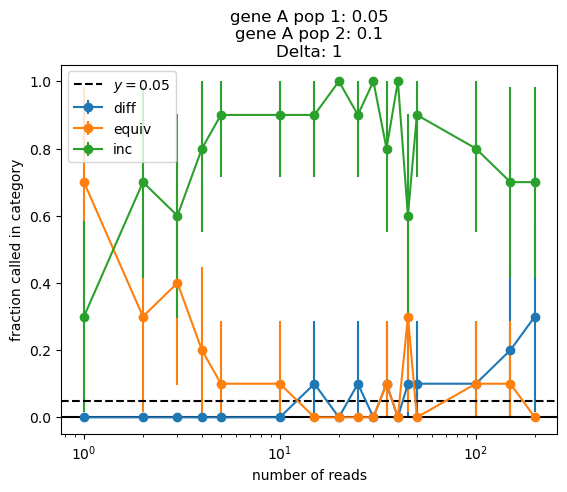

In [11]:
plt.errorbar(out["numReads"], out["frac_sig_diff"], yerr = [out["frac_sig_diff"] - out["frac_sig_diff_lower"],
            out["frac_sig_diff_upper"] - out["frac_sig_diff"] ], marker = "o", label = "diff")
plt.errorbar(out["numReads"], out["frac_sig_equiv"], yerr = [out["frac_sig_equiv"] - out["frac_sig_equiv_lower"],
            out["frac_sig_equiv_upper"] - out["frac_sig_equiv"] ], marker = "o", label = "equiv")
plt.errorbar(out["numReads"], out["frac_sig_inc"], yerr = [out["frac_sig_inc"] - out["frac_sig_inc_lower"],
            out["frac_sig_inc_upper"] - out["frac_sig_inc"] ], marker = "o", label = "inc")
plt.xscale("log")
plt.axhline(y=0.05, linestyle="--", color="k", label = "$y = 0.05$")
plt.axhline(y=0.0, color="k")

plt.legend()
plt.xlabel("number of reads")
plt.ylabel("fraction called in category")
plt.title("gene A pop 1: {}\ngene A pop 2: {}\nDelta: {}".format(geneA_fracs[0], geneA_fracs[1], delta))
plt.savefig("{}pop1_{}_pop2_{}_delt_{}.png".format(outpath, *geneA_fracs, delta),bbox_inches='tight')
plt.show()